# PREPROCESSING DATA

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import  metrics
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix, confusion_matrix, f1_score
import os
import mlflow
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings




dataset=pd.read_csv("clean_dataset2.csv")
dataset.target.replace(["paid_with_delay","paid_in_time"], 1, inplace=True)
dataset.target.replace(["unpaid"], 0, inplace=True)
dataset.rename(columns={"target": "paid"}, inplace=True)

# %%
# Separate target variable Y from features X
target_name = 'paid'

print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()


# %%
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

# %%
dataset.columns

# %%
# First : always divide dataset into train set & test set !!
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
# test_size indicates the proportion of rows from X and Y that will go into the test dataset while 
# maintaining the correspondance between the rows from X and Y 

# random_state is an argument that can be found in all functions that have a pseudo-random behaviour
# if random_state is not stated the function will derive a different random result everytime the cell 
# runs, if random_state is given a value the results will be the same everytime the cell runs while
# each different value of radom_state will derive a specific result
print("...Done.")
print()

# %%
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

# %%
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
#print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder()  #use sparse=False for KNNImputer

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
print("...Done")
#print(X_train[0:5,:])

# Label encoding
print("Encoding labels...")
#print(Y_train[0:5])
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
#print(Y_train[0:5])


#dataset info
dataset.info()

# %%
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
#print(X_test[0:5,:])
X_test = featureencoder.transform(X_test)
print("...Done")
#print(X_test[0:5,:])

# Label encoding
print("Encoding labels...")
#print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
#print(Y_test[0:5])



Separating labels from features...
...Done.
0    1
1    0
2    0
3    0
4    0
Name: paid, dtype: int64

   isMale birthGovernorateTranslate       maritalStatus  detectionConfidence  \
0       1                     Cairo             married             0.716062   
1       1                 Kaliobeya             married             0.910078   
2       1               Ash Sharqia             married             0.796427   
3       1                     Cairo  unknown or widowed             0.923198   
4       1                     Cairo  unknown or widowed             0.900118   

                 joyLikelihood                underExposedLikelihood  \
0  VERY_UNLIKELY_joyLikelihood  VERY_UNLIKELY_underExposedLikelihood   
1  VERY_UNLIKELY_joyLikelihood  VERY_UNLIKELY_underExposedLikelihood   
2  VERY_UNLIKELY_joyLikelihood  VERY_UNLIKELY_underExposedLikelihood   
3  VERY_UNLIKELY_joyLikelihood  VERY_UNLIKELY_underExposedLikelihood   
4         LIKELY_joyLikelihood  VERY_UNLIKELY_underExp

# MACHINE LEARNING MODEL

In [7]:
# Specified Parameters 
params = {'C': [0.05, 0.1, 0.2, 0.3, 0.5, 1, 2], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}

# Instanciate and fit the model 
classifier = LogisticRegression()

gridsearch = GridSearchCV(classifier, params, scoring="f1", refit = True, n_jobs=-1, cv=10)# cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)


#confusion matrix
confusion_matrix_train = confusion_matrix(Y_train, (gridsearch.predict(X_train)))
confusion_matrix_test = confusion_matrix(Y_test, (gridsearch.predict(X_test)))

test_true_negative = confusion_matrix_test[0][0]
test_true_positive = confusion_matrix_test[1][1]
test_false_positive = confusion_matrix_test[0][1]
test_false_negative = confusion_matrix_test[1][0]

train_true_negative = confusion_matrix_train[0][0]
train_true_positive = confusion_matrix_train[1][1]
train_false_positive = confusion_matrix_train[0][1]
train_false_negative = confusion_matrix_train[1][0]

#score to predict 
train_score_roc_auc=roc_auc_score(Y_train, gridsearch.predict_proba(X_train)[:,1])
test_score_roc_auc=roc_auc_score(Y_test, gridsearch.predict_proba(X_test)[:,1])
train_f1_score=f1_score(Y_train, (gridsearch.predict(X_train)), average='binary')
test_f1_score=f1_score(Y_test, (gridsearch.predict(X_test)), average='binary')

#print score
print("train roc_auc score=:",train_score_roc_auc)
print("test roc_auc score=:",test_score_roc_auc)
print("train f1 score=:",train_f1_score)
print("test f1score=:",test_f1_score)

train roc_auc score=: 0.9866725471707678
test roc_auc score=: 0.9856008287292818
train f1 score=: 0.9818840579710145
test f1score=: 0.9846153846153846


In [8]:
#get the best parameters
gridsearch.best_params_

{'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'}

In [9]:
#initialise a model with best params and fit it
lr=LogisticRegression(**gridsearch.best_params_)
lr.fit(X_train, Y_train)

LogisticRegression(C=0.05, penalty='l1', solver='liblinear')

# FEATURES IMPORTANCE

coefficients are:  [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.95597951  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.    

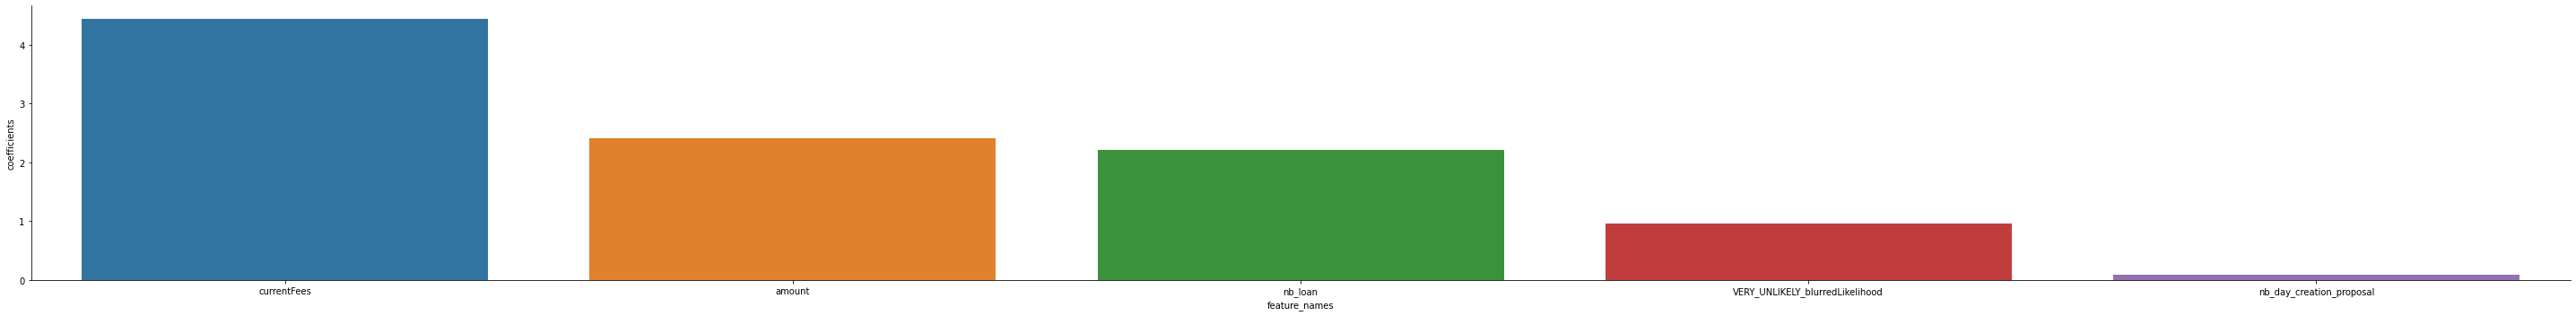

In [10]:
print("coefficients are: ", lr.coef_) 
print("Constant is: ", lr.intercept_)

# Access transformers from feature_encoder
print("All transformers are: ", featureencoder.transformers_)

# Access one specific transformer
print("One Hot Encoder transformer is: ", featureencoder.transformers_[0][1])

# Print categories
categorical_column_names = featureencoder.transformers_[0][1].categories_
categorical_column_names_1=[]
for i in range (len(categorical_column_names)):
    for j in range (len(categorical_column_names[i])):
        
        categorical_column_names_1.append(categorical_column_names[i][j])



categorical_column_names=categorical_column_names_1
print("Categorical columns are: ", categorical_column_names)

numerical_column_names = X.loc[:, numeric_features].columns # using the .columns attribute gives us the name of the column 
print("numerical columns are: ", numerical_column_names)

# Append all columns 
all_column_names = np.append(categorical_column_names, numerical_column_names)
all_column_names

# Feature importance 
feature_importance = pd.DataFrame({
    "feature_names": all_column_names,
    "coefficients":lr.coef_[0]
})

feature_importance



feature_importance1 = feature_importance.drop(feature_importance[feature_importance.coefficients==0].index)
feature_importance1.reset_index(drop=True, inplace=True)
feature_importance1.sort_values(by='coefficients', ascending=False, inplace=True)
#feature_importance1=feature_importance1.iloc[:6,:]


import seaborn as sns

# Set coefficient to absolute values to rank features
feature_importance1["coefficients"] = feature_importance1["coefficients"].abs()

# Visualize ranked features using seaborn
sns.catplot(x="feature_names", 
            y="coefficients", 
            data=feature_importance1.sort_values(by="coefficients", ascending=False), 
            kind="bar",
            aspect=120/15) # Resize graph

In [11]:
feature_importance1.sort_values("coefficients", ascending=False).head(10)

,feature_names,coefficients
2,currentFees,4.438717
1,amount,2.406049
3,nb_loan,2.209225
0,VERY_UNLIKELY_blurredLikelihood,0.955980
4,nb_day_creation_proposal,0.091719


# CONFUSION MATRIX

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


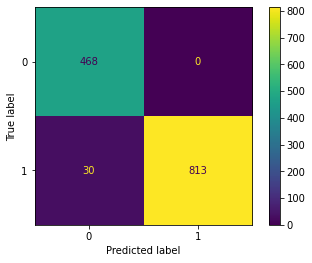

In [12]:
#train confusion matrix 
cm = plot_confusion_matrix(gridsearch, X_train, Y_train)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


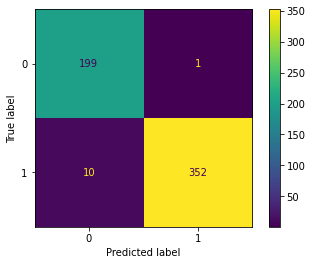

In [13]:
#test confusion matrix 
cm = plot_confusion_matrix(gridsearch, X_test, Y_test)

# AUC_ROC CURVE

In [14]:
import matplotlib.pyplot as plt
from sklearn import  metrics

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


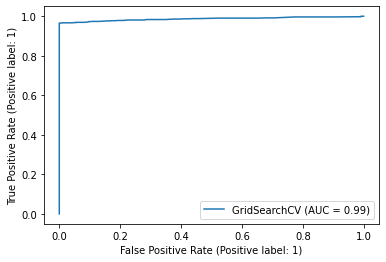

In [15]:
#plot train auc_roc curve
metrics.plot_roc_curve(gridsearch, X_train, Y_train) 
plt.show()

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


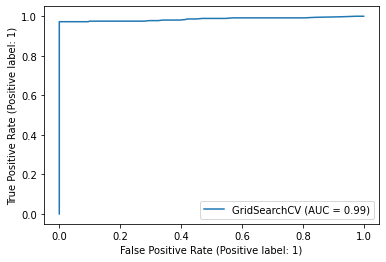

In [16]:
#plot test auc_roc curve
metrics.plot_roc_curve(gridsearch, X_test, Y_test) 
plt.show()